In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import time
import tqdm
import math
import random

In [3]:
df = pd.read_csv('datasets/heart.csv')

In [4]:
target_col = 'target'

In [5]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [6]:
df[target_col].value_counts()

1    165
0    138
Name: target, dtype: int64

In [7]:
df[target_col].value_counts()/len(df)

1    0.544554
0    0.455446
Name: target, dtype: float64

# Try different train size and check results

In [8]:
from src.dataset import Dataset

In [9]:
from src.sampling_methods.sampling_methods import RandomSample, XgboostSubsample, TreeSample, CostumeSample, sampling_utils

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(target_col, axis=1), df[target_col], test_size=0.2, shuffle = True)

In [11]:
dataset = Dataset(df, X_train, y_train, X_test, y_test, target_col, f1_score)

### regular methods

In [12]:
random_sample = RandomSample('random')
xgboost_sample = XgboostSubsample('xgb_subsample')
tree_sample = TreeSample('tree')

### imblearn methods

In [13]:
from sklearn.cluster import MiniBatchKMeans
from imblearn.under_sampling import ClusterCentroids
from functools import partial

In [14]:
def cluster_sample_function(dataset, p):
    values = list(dataset.y_train.unique())
    cnn = ClusterCentroids(estimator=MiniBatchKMeans(n_clusters=100),
                           sampling_strategy={v: math.ceil(p * len(dataset.y_train[dataset.y_train == v])) for v in values})
    X_real_train, y_real_train = cnn.fit_resample(X_train, y_train)
    return X_real_train, y_real_train

In [15]:
cluster = CostumeSample('cluster', cluster_sample_function)

In [16]:
def cnn_sample_function(dataset, p):
    cnn = CondensedNearestNeighbour()
    X_real_train, y_real_train = cnn.fit_resample(dataset.X_train, dataset.y_train)
    return X_real_train, y_real_train

In [17]:
cnn = CostumeSample('cnn', cnn_sample_function)

## Test

In [18]:
random_sample.test_sample_method(dataset, trials_number=2, print_results=True)

 33%|████████████████████████████                                                        | 2/6 [00:00<00:00,  8.57it/s]

(0.6666666666666666, 0.056000709533691406, 0.05371900826446281)
(0.6, 0.05600094795227051, 0.05371900826446281)
(0.8648648648648648, 0.0579988956451416, 0.09917355371900827)
(0.7887323943661972, 0.06000089645385742, 0.09917355371900827)


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:00<00:00,  8.01it/s]

(0.6865671641791046, 0.06000041961669922, 0.19834710743801653)
(0.7301587301587302, 0.0559995174407959, 0.19834710743801653)
(0.8125, 0.06500077247619629, 0.30165289256198347)
(0.7945205479452054, 0.06899833679199219, 0.30165289256198347)


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.59it/s]

(0.8181818181818182, 0.0670006275177002, 0.40082644628099173)
(0.8484848484848486, 0.06599807739257812, 0.40082644628099173)
(0.8405797101449276, 0.06699824333190918, 0.7479338842975206)
(0.7878787878787878, 0.07000136375427246, 0.7479338842975206)


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.88it/s]


In [19]:
xgboost_sample.test_sample_method(dataset, trials_number=2, print_results=True, update_pcts=False)

 33%|████████████████████████████                                                        | 2/6 [00:00<00:00,  8.54it/s]

(0.7692307692307692, 0.06099748611450195)
(0.7741935483870968, 0.05900001525878906)
(0.8695652173913043, 0.05699467658996582)
(0.8529411764705883, 0.055999755859375)


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:00<00:00,  8.07it/s]

(0.8823529411764706, 0.06000065803527832)
(0.8333333333333333, 0.06399869918823242)
(0.875, 0.06399989128112793)
(0.8709677419354839, 0.06300616264343262)


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:00<00:00,  7.86it/s]

(0.8115942028985507, 0.06499791145324707)
(0.8529411764705883, 0.06500005722045898)
(0.8181818181818182, 0.08099937438964844)


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.72it/s]

(0.8115942028985507, 0.07200050354003906)


In [20]:
tree_sample.test_sample_method(dataset, trials_number=2, print_results=True)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

(0.8181818181818182, 0.11700105667114258, 0.2024793388429752)


 17%|██████████████                                                                      | 1/6 [00:00<00:01,  4.39it/s]

(0.71875, 0.11099934577941895, 0.2066115702479339)
(0.7222222222222221, 0.11904048919677734, 0.23553719008264462)


 33%|████████████████████████████                                                        | 2/6 [00:00<00:00,  4.30it/s]

(0.7692307692307692, 0.1150364875793457, 0.2396694214876033)
(0.8450704225352113, 0.11499953269958496, 0.32231404958677684)


 50%|██████████████████████████████████████████                                          | 3/6 [00:00<00:00,  4.30it/s]

(0.8656716417910447, 0.11503291130065918, 0.3140495867768595)
(0.8059701492537314, 0.12906146049499512, 0.4132231404958678)


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:00<00:00,  4.16it/s]

(0.8358208955223881, 0.1230010986328125, 0.4132231404958678)
(0.7936507936507938, 0.12299942970275879, 0.49586776859504134)


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:01<00:00,  4.12it/s]

(0.821917808219178, 0.1230006217956543, 0.49586776859504134)
(0.7941176470588236, 0.12951350212097168, 0.8140495867768595)


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.16it/s]

(0.8059701492537314, 0.11500096321105957, 0.8099173553719008)


In [21]:
cluster.test_sample_method(dataset, print_results=True, trials_number=2, percents=sampling_utils.DEFAULT_PCT[:1])

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change 

(0.6567164179104478, 0.31834912300109863, 0.05371900826446281)
(0.6567164179104478, 0.18799901008605957, 0.05371900826446281)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


C:\Users\Aviv\PycharmProjects\thesis\src\sampling_methods\sampling_base.py:69: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.errorbar(self.pct, self.scores, yerr=self.stds, fmt='bo', color=color, label=self.name, capsize=4)


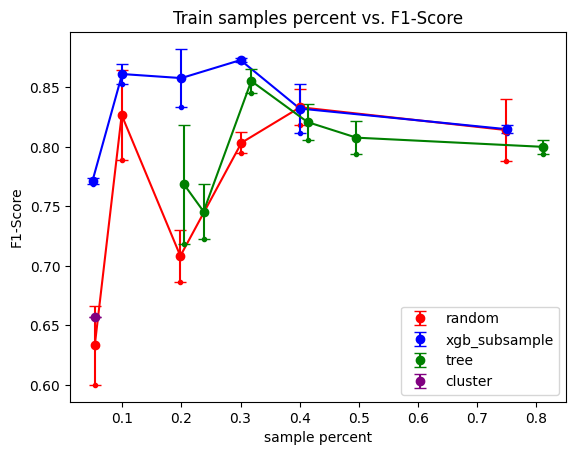

In [22]:
random_sample.print_scores()
xgboost_sample.print_scores('b')
tree_sample.print_scores('g')
cluster.print_scores('purple')

plt.title('Train samples percent vs. F1-Score')
plt.xlabel('sample percent')
plt.ylabel('F1-Score')

plt.legend()

C:\Users\Aviv\PycharmProjects\thesis\src\sampling_methods\sampling_base.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(self.pct, self.times, 'bo', color=color, label=self.name)


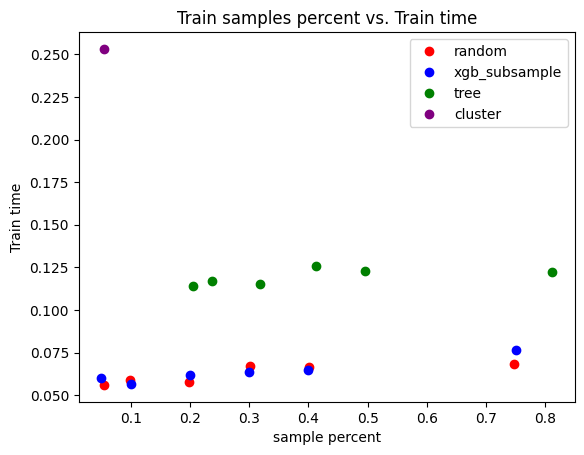

In [23]:
random_sample.print_times()
xgboost_sample.print_times('b')
tree_sample.print_times('g')
cluster.print_times('purple')

plt.title('Train samples percent vs. Train time')
plt.xlabel('sample percent')
plt.ylabel('Train time')

plt.legend()

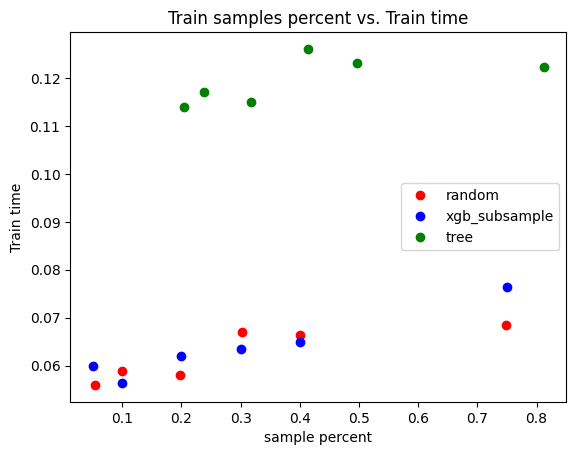

In [24]:
random_sample.print_times()
xgboost_sample.print_times('b')
tree_sample.print_times('g')

plt.title('Train samples percent vs. Train time')
plt.xlabel('sample percent')
plt.ylabel('Train time')
plt.legend()

In [25]:
small_pct = [0.001, 0.003, 0.005, 0.007, 0.01, 0.015, 0.02, 0.05, 0.1]

In [26]:
random_small = RandomSample('random')
xgboost_small = XgboostSubsample('xgb_subsample')
tree_small = TreeSample('tree')

In [27]:
cluster_small = CostumeSample('cluster', cluster_sample_function)

In [28]:
random_small.test_sample_method(dataset, trials_number=2, print_results=True, percents=small_pct)

 22%|██████████████████▋                                                                 | 2/9 [00:00<00:00, 13.33it/s]

[22:11:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:1517: Empty dataset at worker: 0
[22:11:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:1517: Empty dataset at worker: 0
[22:11:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:1517: Empty dataset at worker: 0
[22:11:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:1517: Empty dataset at worker: 0
[22:11:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:1517: Empty dataset at worker: 0
[22:11:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group

 44%|█████████████████████████████████████▎                                              | 4/9 [00:00<00:00, 10.49it/s]

(0.0, 0.06600236892700195, 0.008264462809917356)
(0.0, 0.049997806549072266, 0.008264462809917356)
(0.0, 0.050034523010253906, 0.008264462809917356)
(0.0, 0.06600236892700195, 0.008264462809917356)


 67%|████████████████████████████████████████████████████████                            | 6/9 [00:00<00:00,  9.53it/s]

(0.0, 0.055999755859375, 0.008264462809917356)
(0.0, 0.05499839782714844, 0.01652892561983471)
(0.0, 0.05300092697143555, 0.01652892561983471)
(0.7021276595744682, 0.053999900817871094, 0.02066115702479339)


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:00<00:00,  9.34it/s]

(0.7021276595744682, 0.053998708724975586, 0.02066115702479339)
(0.7123287671232875, 0.05699944496154785, 0.05371900826446281)
(0.8, 0.05200004577636719, 0.05371900826446281)
(0.9142857142857143, 0.056001901626586914, 0.09917355371900827)


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.59it/s]

(0.8732394366197183, 0.057997941970825195, 0.09917355371900827)


In [29]:
xgboost_small.test_sample_method(dataset, trials_number=2, print_results=True, update_pcts=False, percents=small_pct)

 11%|█████████▎                                                                          | 1/9 [00:00<00:00,  9.01it/s]

(0.0, 0.05799984931945801)
(0.0, 0.0520014762878418)
(0.0, 0.05300140380859375)


 22%|██████████████████▋                                                                 | 2/9 [00:00<00:00,  9.30it/s]

(0.0, 0.04999828338623047)
(0.7021276595744682, 0.052997589111328125)


 33%|████████████████████████████                                                        | 3/9 [00:00<00:00,  9.36it/s]

(0.7021276595744682, 0.05099844932556152)
(0.0, 0.05500078201293945)


 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:00<00:00,  9.51it/s]

(0.7021276595744682, 0.0500028133392334)
(0.7021276595744682, 0.051000118255615234)
(0.7021276595744682, 0.049001216888427734)


 67%|████████████████████████████████████████████████████████                            | 6/9 [00:00<00:00,  9.44it/s]

(0.7021276595744682, 0.05408024787902832)
(0.0, 0.05058574676513672)


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:00<00:00,  9.34it/s]

(0.696969696969697, 0.057071685791015625)
(0.8524590163934426, 0.04913640022277832)
(0.8387096774193549, 0.05217432975769043)


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:00<00:00,  9.27it/s]

(0.7826086956521738, 0.05557441711425781)
(0.8787878787878788, 0.05405926704406738)


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.20it/s]

(0.84375, 0.06306123733520508)


In [30]:
tree_small.test_sample_method(dataset, trials_number=2, print_results=True, percents=small_pct)

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

(0.7076923076923077, 0.11469030380249023, 0.18181818181818182)


 11%|█████████▎                                                                          | 1/9 [00:00<00:01,  4.32it/s]

(0.5862068965517241, 0.11605358123779297, 0.19008264462809918)
(0.7222222222222221, 0.16499972343444824, 0.1859504132231405)


 22%|██████████████████▋                                                                 | 2/9 [00:00<00:01,  3.78it/s]

(0.732394366197183, 0.12000155448913574, 0.1859504132231405)
(0.6956521739130435, 0.12199807167053223, 0.1859504132231405)


 33%|████████████████████████████                                                        | 3/9 [00:00<00:01,  3.94it/s]

(0.5945945945945946, 0.1159665584564209, 0.1859504132231405)
(0.65625, 0.12799882888793945, 0.19008264462809918)


 44%|█████████████████████████████████████▎                                              | 4/9 [00:00<00:01,  4.05it/s]

(0.6478873239436619, 0.10699939727783203, 0.18181818181818182)
(0.6440677966101696, 0.11500048637390137, 0.18181818181818182)


 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:01<00:00,  4.16it/s]

(0.6666666666666666, 0.11200165748596191, 0.18181818181818182)
(0.6027397260273972, 0.12099909782409668, 0.1859504132231405)


 67%|████████████████████████████████████████████████████████                            | 6/9 [00:01<00:00,  4.16it/s]

(0.6666666666666666, 0.11699938774108887, 0.1859504132231405)
(0.6666666666666666, 0.11000204086303711, 0.19421487603305784)
(0.6956521739130435, 0.10299849510192871, 0.19008264462809918)


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:01<00:00,  4.37it/s]

(0.619718309859155, 0.1100015640258789, 0.2024793388429752)
(0.8253968253968254, 0.1100003719329834, 0.2024793388429752)
(0.6349206349206349, 0.10599875450134277, 0.2396694214876033)


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.23it/s]

(0.732394366197183, 0.11400032043457031, 0.24380165289256198)


In [31]:
cluster_small.test_sample_method(dataset, print_results=True, trials_number=2, percents=small_pct)

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

(0.0, 0.1379988193511963, 0.008264462809917356)


C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 11%|█████████▎ 

(0.0, 0.14700055122375488, 0.008264462809917356)


C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(0.0, 0.19499993324279785, 0.008264462809917356)


C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 22%|██████████████████▋                                                                 | 2/9 [00:00<00:02,  3.15it/s]

(0.0, 0.14300131797790527, 0.008264462809917356)


C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(0.0, 0.16499853134155273, 0.008264462809917356)


C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 33%|████████████████████████████                                                        | 3/9 [00:00<00:01,  3.13it/s]

(0.0, 0.15600013732910156, 0.008264462809917356)


C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(0.0, 0.15399932861328125, 0.008264462809917356)


C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 44%|█████████████████████████████████████▎                                              | 4/9 [00:01<00:01,  3.15it/s]

(0.0, 0.15799927711486816, 0.008264462809917356)


C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(0.0, 0.15700006484985352, 0.01652892561983471)


C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:01<00:01,  3.09it/s]

(0.0, 0.1770024299621582, 0.01652892561983471)


C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(0.0, 0.15200018882751465, 0.01652892561983471)


C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 67%|████████████████████████████████████████████████████████                            | 6/9 [00:01<00:00,  3.12it/s]

(0.0, 0.16099882125854492, 0.01652892561983471)


C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(0.0, 0.1770002841949463, 0.024793388429752067)


C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:02<00:00,  3.04it/s]

(0.0, 0.1659994125366211, 0.024793388429752067)


C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(0.6567164179104478, 0.17351174354553223, 0.05371900826446281)


C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:02<00:00,  3.02it/s]

(0.8571428571428571, 0.16100049018859863, 0.05371900826446281)


C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Aviv\Anaconda3\envs\thesis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|███████████

(0.7272727272727273, 0.20499825477600098, 0.10330578512396695)
(0.6875, 0.1979994773864746, 0.10330578512396695)


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.00it/s]


C:\Users\Aviv\PycharmProjects\thesis\src\sampling_methods\sampling_base.py:69: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.errorbar(self.pct, self.scores, yerr=self.stds, fmt='bo', color=color, label=self.name, capsize=4)


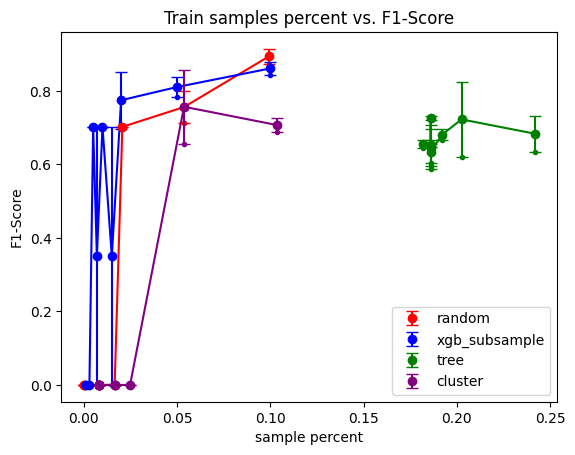

In [32]:
random_small.print_scores()
xgboost_small.print_scores('b')
tree_small.print_scores('g')
cluster_small.print_scores('purple')

plt.title('Train samples percent vs. F1-Score')
plt.xlabel('sample percent')
plt.ylabel('F1-Score')

plt.legend()

C:\Users\Aviv\PycharmProjects\thesis\src\sampling_methods\sampling_base.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(self.pct, self.times, 'bo', color=color, label=self.name)


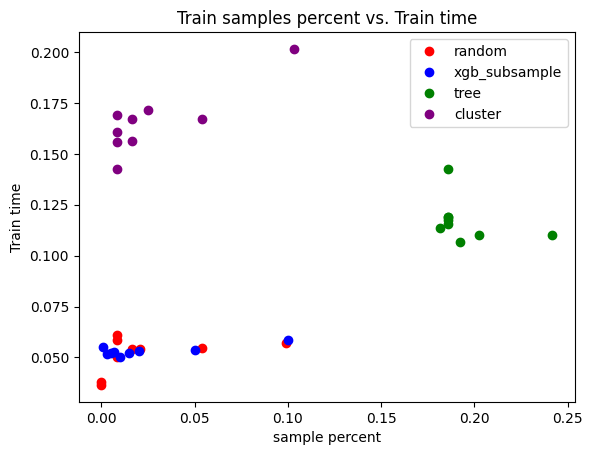

In [33]:
random_small.print_times()
xgboost_small.print_times('b')
tree_small.print_times('g')
cluster_small.print_times('purple')

plt.title('Train samples percent vs. Train time')
plt.xlabel('sample percent')
plt.ylabel('Train time')

plt.legend()

## Visualize decision tree

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [35]:
singel_tree_model = DecisionTreeClassifier(min_weight_fraction_leaf=0.05, class_weight='balanced')

In [36]:
s = time.time()
singel_tree_model.fit(X_train, y_train)
time.time() - s

0.004000425338745117

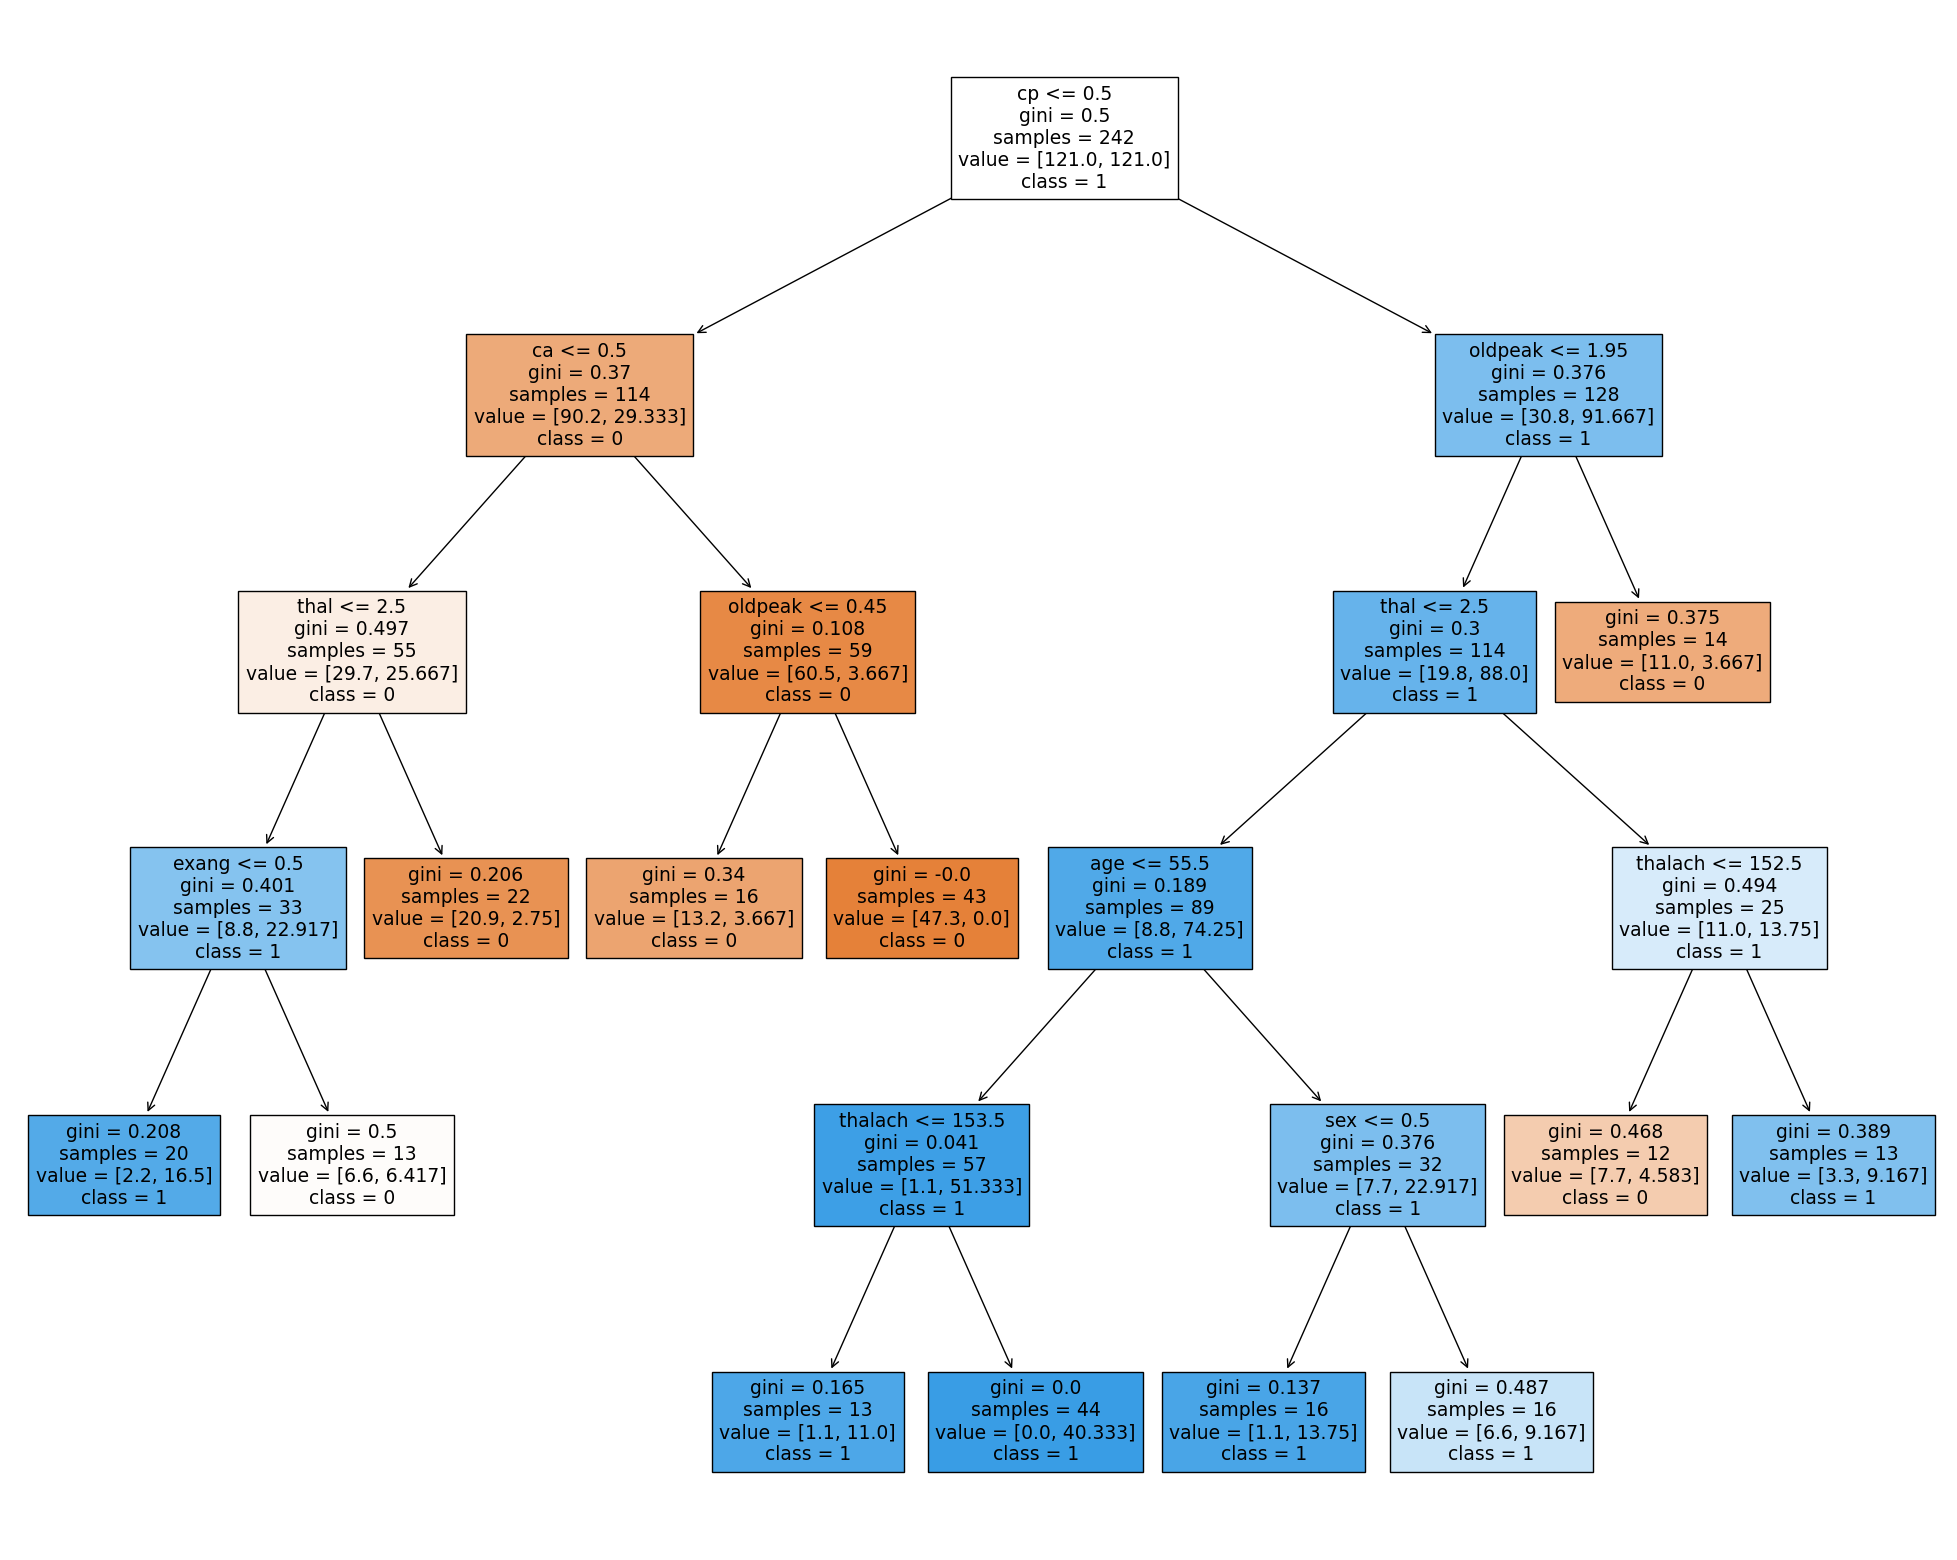

In [37]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(singel_tree_model, 
                   feature_names=X_train.columns,  
                   class_names=['0','1'],
                   filled=True,
                   )

## XGBoost paths

In [38]:
from src.gbdt_model_paths.model_path import ModelPath

In [39]:
model_path = ModelPath(xgb.XGBClassifier(max_depth=3), dataset)

C:\Users\Aviv\PycharmProjects\thesis\src\gbdt_model_paths\model_path.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.X_diff[f'diff_{n}'] = round(self.X_diff[f'pred_{n}'] - self.X_diff[f'pred_{n - 1}'], 5)
C:\Users\Aviv\PycharmProjects\thesis\src\gbdt_model_paths\model_path.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.X_diff[f'pred_{n}'] = model.predict(dataset.X_train, iteration_range=(0, n+1), output_margin=True)
C:\Users\Aviv\PycharmProjects\thesis\src\gbdt_model_paths\model_path.py:16: PerformanceWarnin

### EDA

In [40]:
#for num_trees in range(0, model_path.num_trees, 5):
for num_trees in range(0, 31, 5):
    print(f'trees number: {num_trees}')
    model_path.get_groups_info(model_path.X_diff.groupby([f'diff_{i}' for i in range(num_trees + 1)]))
    print('\n')

C:\Users\Aviv\PycharmProjects\thesis\src\gbdt_model_paths\model_path.py:23: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in grouped:


trees number: 0
1: 0, 0: 1, all: 8
part of groups: 0.125
part of examples: 0.028925619834710745


trees number: 5
1: 57, 0: 47, all: 115
part of groups: 0.9043478260869565
part of examples: 0.8884297520661157


trees number: 10
1: 104, 0: 87, all: 191
part of groups: 1.0
part of examples: 1.0


trees number: 15
1: 114, 0: 106, all: 220
part of groups: 1.0
part of examples: 1.0


trees number: 20
1: 121, 0: 110, all: 231
part of groups: 1.0
part of examples: 1.0


trees number: 25
1: 126, 0: 110, all: 236
part of groups: 1.0
part of examples: 1.0


trees number: 30
1: 129, 0: 110, all: 239
part of groups: 1.0
part of examples: 1.0




(array([229.,   5.,   0.,   0.]),
 array([   1.,    2.,   10.,  100., 1000.]),
 <BarContainer object of 4 artists>)

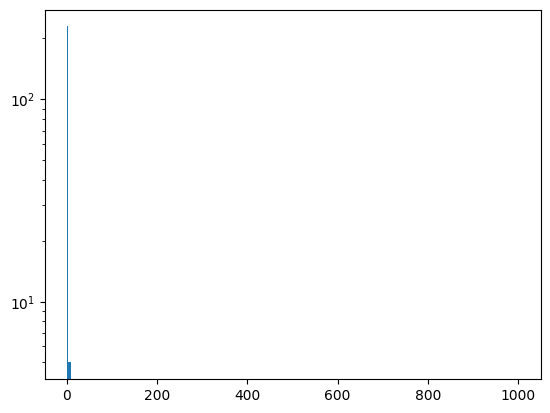

In [41]:
grouped_df = model_path.X_diff.groupby([f'diff_{i}' for i in range(25)]).count()[[target_col]]
plt.hist(grouped_df[target_col], log=True, bins=[1,2,10,100,1000])

In [42]:
ratios, counts = model_path.get_groups_info(model_path.X_diff.groupby([f'diff_{i}' for i in range(26)]), print_stats=False)
sum([counts[i] for i in range(len(ratios)) if counts[i] > 10]) / sum(counts)

0.0

In [43]:
ratios, counts = model_path.get_groups_info(model_path.X_diff.groupby([f'diff_{i}' for i in range(26)]), print_stats=False)
sum([counts[i] for i in range(len(ratios)) if counts[i] > 10]) / sum(counts)

0.0

(array([236.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

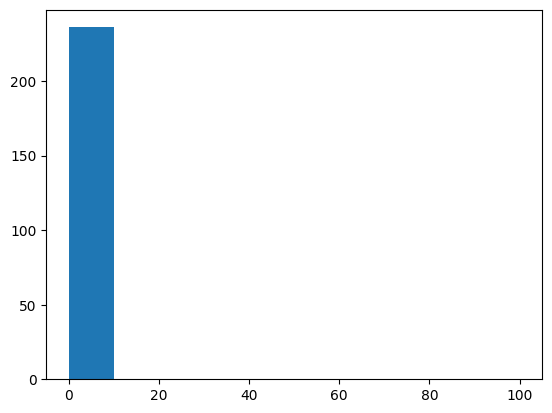

In [44]:
plt.hist(counts, range=(0, 100))

(array([110.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 126.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

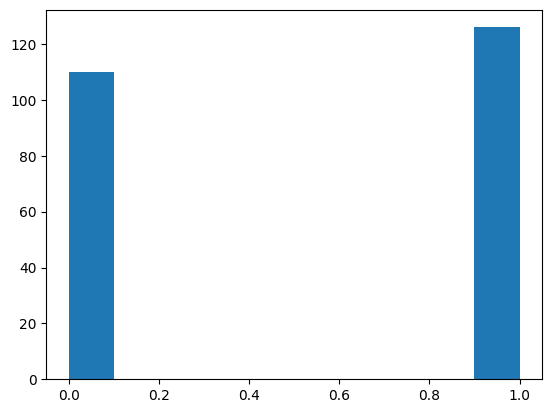

In [45]:
plt.hist(ratios)

In [46]:
sum([counts[i] for i in range(len(ratios)) if counts[i] > 10]) / sum(counts)

0.0

In [47]:
len(counts) / sum(counts)

0.9752066115702479

### Sample by leafs combinations

In [48]:
colors = ['g', 'b', 'r', 'c', 'm', 'y', 'k', 'pink'] 

In [49]:
from src.sampling_methods.sampling_methods import XgboostPathSample

In [50]:
experimets = [XgboostPathSample(f'{i} trees', model_path, i) for i in [1, 2, 3, 5]]

In [51]:
for e in experimets:
    print ('#######################################')
    e.test_sample_method(dataset, print_results=True, trials_number=5, percents=sampling_utils.DEFAULT_PCT[:-2])

#######################################


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

(0.625, 0.08391785621643066, 0.09090909090909091)
(0.6875, 0.09600067138671875, 0.09090909090909091)


 25%|█████████████████████                                                               | 1/4 [00:00<00:01,  2.10it/s]

(0.7397260273972603, 0.10000014305114746, 0.09090909090909091)
(0.6849315068493151, 0.09751343727111816, 0.09090909090909091)
(0.7466666666666666, 0.0969996452331543, 0.09090909090909091)
(0.7272727272727273, 0.10299897193908691, 0.1322314049586777)
(0.7894736842105263, 0.10099911689758301, 0.1322314049586777)


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00,  2.02it/s]

(0.7647058823529412, 0.10300207138061523, 0.1322314049586777)
(0.6666666666666667, 0.09799766540527344, 0.1322314049586777)
(0.6774193548387097, 0.09999656677246094, 0.1322314049586777)
(0.8529411764705883, 0.10451149940490723, 0.2231404958677686)
(0.8787878787878788, 0.10600066184997559, 0.2231404958677686)
(0.8059701492537314, 0.10400128364562988, 0.2231404958677686)


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:01<00:00,  1.97it/s]

(0.8787878787878788, 0.10200023651123047, 0.2231404958677686)
(0.8405797101449276, 0.10599946975708008, 0.2231404958677686)
(0.7761194029850745, 0.10900330543518066, 0.32644628099173556)
(0.8125, 0.10799670219421387, 0.32644628099173556)
(0.8695652173913043, 0.10299968719482422, 0.32644628099173556)
(0.8387096774193549, 0.11200213432312012, 0.32644628099173556)


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


(0.7868852459016394, 0.10899877548217773, 0.32644628099173556)
#######################################


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

(0.5818181818181818, 0.14299631118774414, 0.24793388429752067)
(0.5925925925925926, 0.1400003433227539, 0.24793388429752067)
(0.7936507936507938, 0.14099836349487305, 0.24793388429752067)
(0.8125, 0.1420297622680664, 0.24793388429752067)


 25%|█████████████████████                                                               | 1/4 [00:00<00:02,  1.41it/s]

(0.71875, 0.1439990997314453, 0.24793388429752067)
(0.71875, 0.14299631118774414, 0.2727272727272727)
(0.689655172413793, 0.14100241661071777, 0.2727272727272727)
(0.7368421052631579, 0.1335155963897705, 0.2727272727272727)
(0.721311475409836, 0.13900017738342285, 0.2727272727272727)


 50%|██████████████████████████████████████████                                          | 2/4 [00:01<00:01,  1.44it/s]

(0.8307692307692308, 0.12499833106994629, 0.2727272727272727)
(0.7575757575757576, 0.11999845504760742, 0.34297520661157027)
(0.7761194029850745, 0.12099933624267578, 0.34297520661157027)
(0.8484848484848486, 0.13700246810913086, 0.34297520661157027)
(0.721311475409836, 0.14302468299865723, 0.34297520661157027)


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:02<00:00,  1.47it/s]

(0.7368421052631579, 0.136000394821167, 0.34297520661157027)
(0.7936507936507938, 0.14299964904785156, 0.4380165289256198)
(0.8253968253968254, 0.1399991512298584, 0.4380165289256198)
(0.7812499999999999, 0.14099907875061035, 0.4380165289256198)
(0.8181818181818182, 0.14255571365356445, 0.4380165289256198)


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.45it/s]


(0.7812499999999999, 0.14099740982055664, 0.4380165289256198)
#######################################


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

(0.7647058823529412, 0.14999818801879883, 0.30991735537190085)
(0.8253968253968254, 0.14356207847595215, 0.30991735537190085)
(0.7575757575757576, 0.15199947357177734, 0.30991735537190085)
(0.6774193548387097, 0.149000883102417, 0.30991735537190085)


 25%|█████████████████████                                                               | 1/4 [00:00<00:02,  1.34it/s]

(0.6666666666666666, 0.15099883079528809, 0.30991735537190085)
(0.676923076923077, 0.14899849891662598, 0.3347107438016529)
(0.6666666666666666, 0.15000033378601074, 0.3347107438016529)
(0.7000000000000001, 0.14999961853027344, 0.3347107438016529)
(0.7741935483870968, 0.1510002613067627, 0.3347107438016529)


 50%|██████████████████████████████████████████                                          | 2/4 [00:01<00:01,  1.33it/s]

(0.8064516129032258, 0.14854097366333008, 0.3347107438016529)
(0.7384615384615384, 0.14755511283874512, 0.3884297520661157)
(0.7692307692307692, 0.14699983596801758, 0.3884297520661157)
(0.8125, 0.14800095558166504, 0.3884297520661157)
(0.8125, 0.1510009765625, 0.3884297520661157)


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:02<00:00,  1.34it/s]

(0.7999999999999999, 0.1495528221130371, 0.3884297520661157)
(0.823529411764706, 0.15208935737609863, 0.47107438016528924)
(0.8615384615384615, 0.1490011215209961, 0.47107438016528924)
(0.8307692307692308, 0.14899992942810059, 0.47107438016528924)
(0.8387096774193549, 0.14999818801879883, 0.47107438016528924)


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.33it/s]


(0.7692307692307692, 0.14700055122375488, 0.47107438016528924)
#######################################


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

(0.7540983606557378, 0.16099977493286133, 0.4380165289256198)
(0.7868852459016394, 0.16300082206726074, 0.4380165289256198)
(0.7761194029850745, 0.16553878784179688, 0.4380165289256198)
(0.761904761904762, 0.16800165176391602, 0.4380165289256198)


 25%|█████████████████████                                                               | 1/4 [00:00<00:02,  1.21it/s]

(0.8, 0.1699984073638916, 0.4380165289256198)
(0.7812499999999999, 0.16500115394592285, 0.45041322314049587)
(0.7741935483870968, 0.17056870460510254, 0.45041322314049587)
(0.7301587301587302, 0.16199922561645508, 0.45041322314049587)
(0.7500000000000001, 0.1660017967224121, 0.45041322314049587)


 50%|██████████████████████████████████████████                                          | 2/4 [00:01<00:01,  1.21it/s]

(0.7575757575757576, 0.16199946403503418, 0.45041322314049587)
(0.7741935483870968, 0.16699886322021484, 0.5)
(0.7878787878787878, 0.17200088500976562, 0.5)
(0.7384615384615384, 0.16700005531311035, 0.5)
(0.7878787878787878, 0.1679995059967041, 0.5)


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:02<00:00,  1.20it/s]

(0.7692307692307692, 0.1660785675048828, 0.5)
(0.761904761904762, 0.22510576248168945, 0.5537190082644629)
(0.7812499999999999, 0.16500091552734375, 0.5537190082644629)
(0.7941176470588236, 0.165999174118042, 0.5537190082644629)
(0.7878787878787878, 0.16199970245361328, 0.5537190082644629)


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]

(0.7692307692307692, 0.16606664657592773, 0.5537190082644629)


C:\Users\Aviv\PycharmProjects\thesis\src\sampling_methods\sampling_base.py:69: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.errorbar(self.pct, self.scores, yerr=self.stds, fmt='bo', color=color, label=self.name, capsize=4)


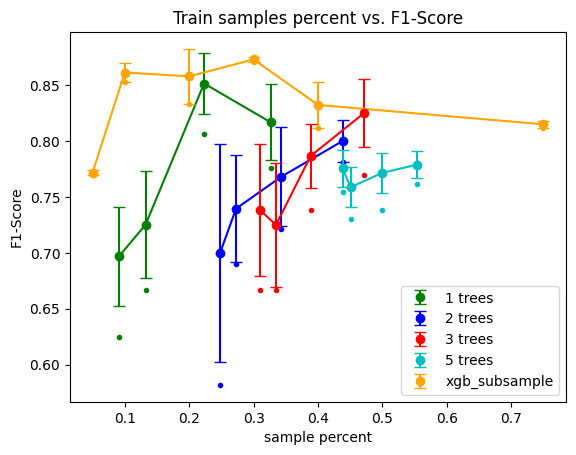

In [52]:
for i, e in enumerate(experimets):
    e.print_scores(colors[i])
xgboost_sample.print_scores('orange')
plt.title('Train samples percent vs. F1-Score')
plt.xlabel('sample percent')
plt.ylabel('F1-Score')
#plt.ylim((0.65,0.85))
#plt.xlim((0.04,0.31))
plt.legend()